In [88]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [89]:
def euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan(x, y):
    return np.sum(np.abs(x - y))

def minkowski(x, y, p=3):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

def cosine(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def hamming(x, y):
    return np.sum(x != y)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [90]:
def knn_predict(X_train, y_train, X_test, k, distance_fn):
    predictions = []

    for test_point in X_test:
        distances = []

        for i in range(len(X_train)):
            dist = distance_fn(test_point, X_train[i])
            distances.append((dist, y_train[i]))

        distances.sort(key=lambda x: x[0])
        neighbors = distances[:k]

        labels = [label for _, label in neighbors]
        predictions.append(max(set(labels), key=labels.count))

    return np.array(predictions)

In [91]:
def confusion_matrix(y_true, y_pred):
    cm = np.zeros((2,2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

def precision_recall(cm):
    precision = cm[1,1] / (cm[0,1] + cm[1,1])
    recall = cm[1,1] / (cm[1,0] + cm[1,1])
    return precision, recall

In [92]:
def confusion_matrix_multi(y_true, y_pred, classes=10):
    cm = np.zeros((classes, classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

In [93]:
def accuracy_table(results, K_values):
    data = []
    for metric in results:
        for i, k in enumerate(K_values):
            data.append([metric, k, results[metric][i]])

    df = pd.DataFrame(
        data,
        columns=["Distance Metric", "K Value", "Accuracy"]
    )
    return df

In [94]:
def pca_2d(X):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx[:2]]
    return X_centered @ eigvecs


In [95]:
def plot_decision_boundary(X, y, X_train, y_train, k, dist_fn, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = knn_predict(X_train, y_train, grid, k, dist_fn)
    preds = preds.reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

Question 1

In [96]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [97]:
df.drop('Unnamed: 32', axis=1, inplace=True)

In [98]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [99]:
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

np.random.seed(42)
indices = np.random.permutation(len(X))

train_size = int(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [100]:
Ks = [3, 4, 9, 20, 47]

distances = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": lambda x, y: minkowski(x, y, 3),
    "Cosine": cosine,
    "Hamming": hamming
}

results_task1 = {}

for name, dist_fn in distances.items():
    accs = []
    for k in Ks:
        preds = knn_predict(X_train, y_train, X_test, k, dist_fn)
        accs.append(accuracy(y_test, preds))
    results_task1[name] = accs


In [101]:
best_preds_1 = knn_predict(
    X_train, y_train, X_test,
    best_k_1, distances[best_metric_1]
)

cm1 = confusion_matrix(y_test, best_preds_1)
precision1, recall1 = precision_recall(cm1)

In [102]:
X_train_pca = pca_2d(X_train)
X_test_pca = pca_2d(X_test)

In [103]:
k1 = best_k_1
dist1 = distances[best_metric_1]

In [104]:
best_metric_1 = max(results_task1, key=lambda x: max(results_task1[x]))
best_k_1 = Ks[np.argmax(results_task1[best_metric_1])]

In [105]:
print("Best Metric:", best_metric_1)
print("Best K:", best_k_1)

Best Metric: Cosine
Best K: 3


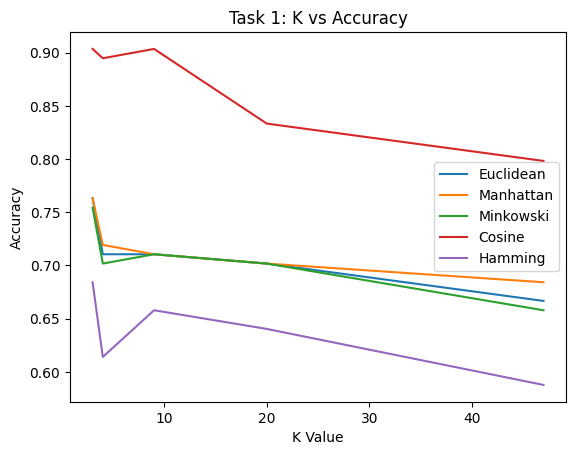

In [106]:
import matplotlib.pyplot as plt

for metric in results_task1:
    plt.plot(Ks, results_task1[metric], label=metric)

plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("Task 1: K vs Accuracy")
plt.legend()
plt.show()

In [107]:
accuracy_table_task1 = accuracy_table(results_task1, Ks)
accuracy_table_task1.sort_values(
    by="Accuracy", ascending=False
)

,Distance Metric,K Value,Accuracy
15,Cosine,3,0.903509
17,Cosine,9,0.903509
16,Cosine,4,0.894737
18,Cosine,20,0.833333
19,Cosine,47,0.798246
5,Manhattan,3,0.763158
0,Euclidean,3,0.763158
10,Minkowski,3,0.754386
6,Manhattan,4,0.719298
2,Euclidean,9,0.710526


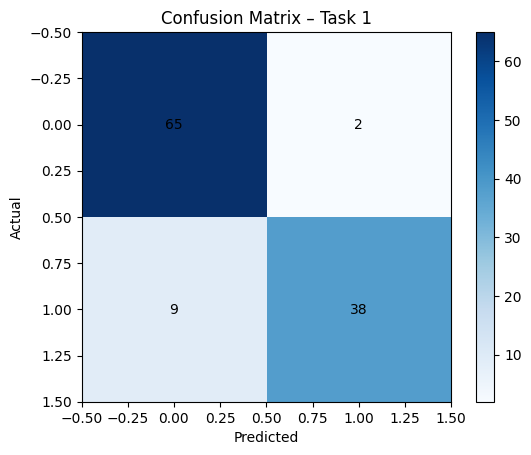

In [108]:
import matplotlib.pyplot as plt

plt.imshow(cm1, cmap='Blues')
plt.title("Confusion Matrix – Task 1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm1[i, j], ha='center', va='center')

plt.show()

In [ ]:
plot_decision_boundary(
    X_train_pca, y_train,
    X_train_pca, y_train,
    k1, dist1,
    "Decision Boundary – Task 1 (Breast Cancer)"
)

In [109]:
print("Precision:\n", precision1)
print("Recall:\n", recall1)

Precision:
 0.95
Recall:
 0.8085106382978723


Question 2

In [116]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

In [117]:
X_train = X_train.reshape(len(X_train), -1) / 255.0
X_test = X_test.reshape(len(X_test), -1) / 255.0

In [119]:
len(X_train)

50000

In [121]:
X_train[0]

array([0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
       0.28235294])

In [122]:
X_train_s = X_train[:2000]
y_train_s = y_train[:2000]

X_test_s = X_test[:500]
y_test_s = y_test[:500]

In [ ]:
results_task2 = {}

for name, dist_fn in distances.items():
    accs = []
    for k in Ks:
        preds = knn_predict(X_train_s, y_train_s, X_test_s, k, dist_fn)
        accs.append(accuracy(y_test_s, preds))
    results_task2[name] = accs


In [ ]:
best_metric_2 = max(results_task2, key=lambda x: max(results_task2[x]))
best_k_2 = Ks[np.argmax(results_task2[best_metric_2])]
print("Best Metric:", best_metric_2)
print("Best K:", best_k_2)

In [ ]:
best_preds = knn_predict(
    X_train_small, y_train_small,
    X_test_small, best_k_2,
    distances[best_metric_2]
)

cm2 = confusion_matrix_multi(
    y_test_s,
    knn_predict(X_train_s, y_train_s, X_test_s, best_k_2, distances[best_metric_2])
)

In [ ]:
X_train_pca2 = pca_2d(X_train_s)

In [ ]:
k2 = best_k_2
dist2 = distances[best_metric_2]


In [ ]:
precision2, recall2 = precision_recall(cm1)
print("Precision:\n", precision2)
print("Recall:\n", recall2)

In [ ]:
for metric in results_task2:
    plt.plot(Ks, results_task2[metric], label=metric)

plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("Task 2: CIFAR-10 K vs Accuracy")
plt.legend()
plt.show()


In [ ]:
accuracy_table_task2 = accuracy_table(results_task2, Ks)
accuracy_table_task2.sort_values(
    by="Accuracy", ascending=False
)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(cm2, cmap='viridis')
plt.title("Confusion Matrix – CIFAR-10")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()

for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(
            j, i, cm2[i, j],
            ha="center", va="center",
            color="white" if cm2[i, j] > cm2.max()/2 else "black",
            fontsize=9
        )

plt.tight_layout()
plt.show()


In [ ]:
plot_decision_boundary(
    X_train_pca2, y_train_s,
    X_train_pca2, y_train_s,
    k2, dist2,
    "Decision Boundary – Task 2 (CIFAR-10)"
)
